In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Models')
sys.path.append('../Protocols')
from cell_models import kernik, protocols, paci_2018

import mod_protocols
import protocol_lib
import mod_kernik as kernik
import mod_trace as trace
from Models.br1977 import BR1977
from ord2011 import ORD2011
import model_response

In [2]:
is_optimized_protocol = False
trial_conditions = "ORD2011_Leem_v1"
if is_optimized_protocol:
    trial_conditions = "ORD2011_504_101_4_-121_61_10_5"
    
prestep = 5000
window = 10
step_size = 5
holding_step = 500
only_end = False
with_artefact = False
model_name = trial_conditions.split('_')[0]
path_to_data = f"ga_results/{trial_conditions}"
if not os.path.exists(path_to_data):
    os.makedirs(path_to_data)


In [3]:
final_protocol = None

if is_optimized_protocol:

    files = os.listdir(path_to_data)
    for f in files:
        if ('pkl' in f) and (f'p{prestep}' in f) and (f'h{holding_step}' in f) and (f'oe{only_end}' in f):
            file_name = f
    print(file_name)
    final_protocol = pickle.load(open(f"{path_to_data}/{file_name}", 'rb'))    
    
else :
    final_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  # <- why?? vo
    final_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
    final_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
    # final_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
    # final_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
    # final_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
    # final_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step
    
print(f'The protocol is {final_protocol.get_voltage_change_endpoints()[-1]} ms')
# times = np.arange(0, final_protocol.get_voltage_change_endpoints()[-1], 1) 
# final_protocol.plot_voltage_clamp_protocol(times)

The protocol is 1320 ms


In [4]:
start_time = time.time()

# Simualatino #########################################################################################################
currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_CaL', 'I_K1', 'I_NaL' ]               
tr = None
if model_name=='ORD2011' :
    model = ORD2011(final_protocol, is_exp_artefact=with_artefact)
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='OHara2017':
    model = '../mmt-model-files/ohara-cipa-v1-2017_VC.mmt'
    tr = model_response.get_model_response_with_myokit(model, final_protocol, prestep=prestep)
elif model_name=='BR1977' :
    currents = ['I_Na', 'I_si', 'I_K1', 'I_x1']
    model = BR1977(final_protocol)  
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='Kernik':
    currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_F', 'I_CaL', 'I_K1'] 
    k = kernik.KernikModel(is_exp_artefact=with_artefact)        
    tr = k.generate_response(final_protocol, is_no_ion_selective=False)
    
# Contributions #########################################################################################################
current_contributions = tr.current_response_info.get_current_contributions( time=tr.t, window=window, step_size=step_size)
max_contributions = tr.current_response_info.get_max_current_contributions(tr.t, window=window, step_size=step_size)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.252790927886963 seconds ---


In [5]:
start_time = time.time()

# Simualatino #########################################################################################################             
tr2 = None
if model_name=='ORD2011' :
    model = ORD2011(final_protocol, is_exp_artefact=with_artefact)
    
    model.change_cell(1)  

    model.ina.G_adj = 1
    model.ikr.G_adj = 1
    model.iks.G_adj = 1    
    model.ito.G_adj = 1
    model.ical.G_adj = 1        
    model.ik1.G_adj = 0.1
    model.inal.G_adj = 1
    # model.inaca.G_adj = 1
    # model.inak.G_adj = 1
    # model.ikb.G_adj = 1
    # model.inab.G_adj = 1
    # model.icab.G_adj = 1
    # model.ipca.G_adj = 1
    
    tr2 = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='OHara2017':
    model = '../mmt-model-files/ohara-cipa-v1-2017_VC.mmt'
    tr2 = model_response.get_model_response_with_myokit(model, final_protocol, prestep=prestep)
elif model_name=='BR1977' :    
    model = BR1977(final_protocol)  
    tr2 = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='Kernik':    
    k = kernik.KernikModel(is_exp_artefact=with_artefact)        
    tr2 = k.generate_response(final_protocol, is_no_ion_selective=False)
      
# Contributions #########################################################################################################
current_contributions2 = tr.current_response_info.get_current_contributions( time=tr2.t, window=window, step_size=step_size)
max_contributions2 = tr2.current_response_info.get_max_current_contributions(tr2.t, window=window, step_size=step_size)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.1828720569610596 seconds ---


In [6]:
def plot_1d(ax, data, title=None, colors=None, ylabel=None, xlim=None, ylim=None):
        
    for i, d in enumerate(data):            
        keys = list(d.keys())
        c = None
        if colors:  
            c = colors[i]
        ax.plot( d[keys[0]], d[keys[1]], label=keys[1], color=c, linewidth=2)               
        
    if title:
        ax.set_title(ylabel)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])    
    if ylabel:
        ax.set_ylabel( ylabel, fontsize=14) 
    ax.set_xlabel('Time (ms)', fontsize=14)  
    ax.tick_params( axis="x", labelsize=14)
    ax.tick_params( axis="y", labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)     
    ax.legend(loc=2, prop={'size': 14})    
    # ax.grid()
    
    return ax

In [11]:
current_name = 'I_Kr'  # ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_CaL', 'I_K1', 'I_NaL' ]    
max_cont = max_contributions[max_contributions['Current']==current_name]
max_cont

,Current,Contribution,Time Start,Time End
6,I_Kr,0.677128,1200.0,1210.0


In [12]:
start_time = max_cont['Time Start'].values[0]
current_contributions[current_contributions['Time Start']==start_time]

,Time Start,Time End,Time Mid,I_Na,I_NaL,I_To,I_CaL,I_CaNa,I_CaK,I_Kr,...,I_NaK,I_Kb,I_Nab,I_Cab,I_pCa,I_F,I_up,I_leak,I_no_ion,I_stim
240,1200,1210,1205.0,0.000021,0.007782,0.001445,0.009658,0.000689,0.000067,0.677128,...,0.092954,0.012941,0.006252,0.005499,0.000085,0.0,0.0,0.0,0.0,0.0


In [13]:
start_time = max_cont['Time Start'].values[0]
current_contributions2[current_contributions2['Time Start']==start_time]

,Time Start,Time End,Time Mid,I_Na,I_NaL,I_To,I_CaL,I_CaNa,I_CaK,I_Kr,...,I_NaK,I_Kb,I_Nab,I_Cab,I_pCa,I_F,I_up,I_leak,I_no_ion,I_stim
240,1200,1210,1205.0,0.000608,0.00332,0.003823,0.000945,0.000059,0.000003,0.608922,...,0.087363,0.003675,0.008621,0.008635,0.000087,0.0,0.0,0.0,0.0,0.0


In [14]:
start_time = max_cont['Time Start'].values[0]
print("Contrl :", current_contributions[current_contributions['Time Start']==start_time][current_name].values[0])
print("Treatment :", current_contributions2[current_contributions2['Time Start']==start_time][current_name].values[0])

Contrl : 0.677128136669383
Treatment : 0.6089221262961646


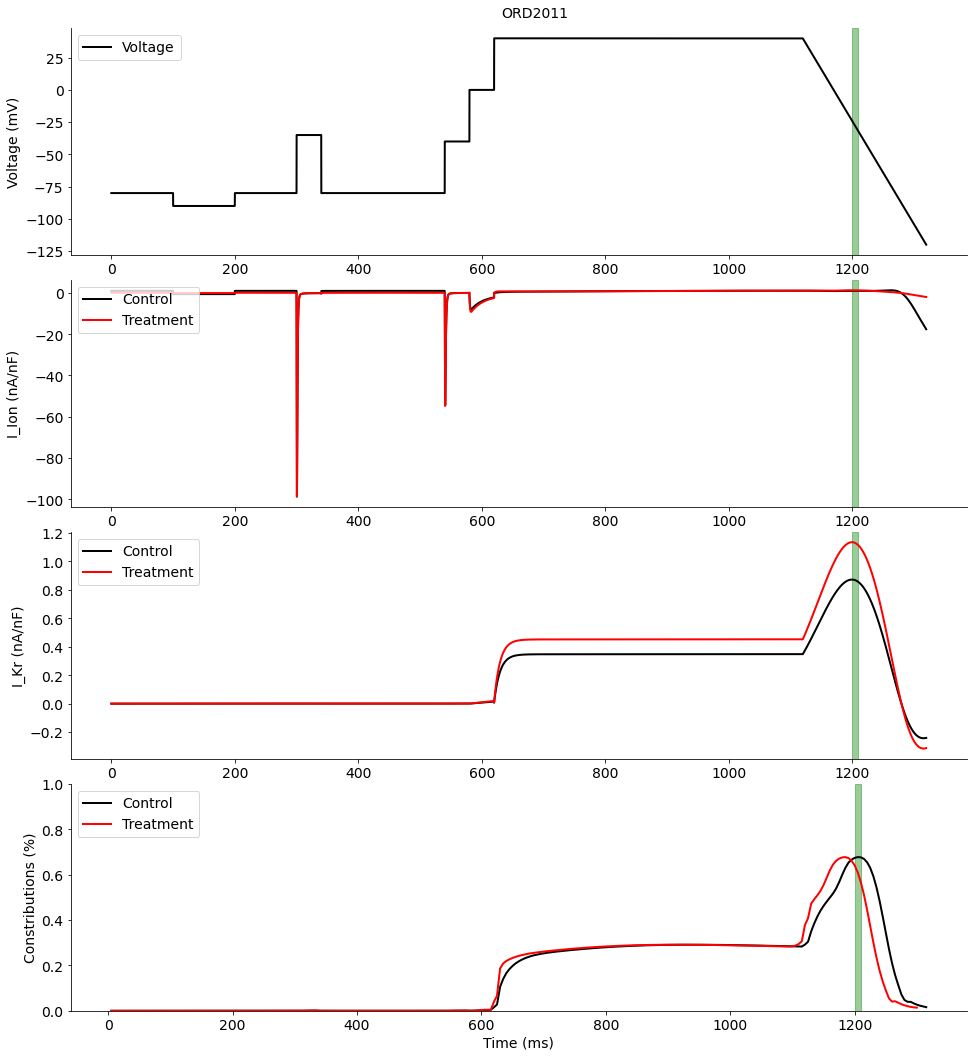

In [15]:
'''
Plot
'''
fig, axes = plt.subplots(4,1, figsize=(15,15))    
fig.suptitle(model_name, fontsize=14)

xlim = None #(9670, 9720)#(start_time-10, start_time+20)
ylim = None #(-30, 3 )

##
plot_1d(axes[0],
        [{'x': tr.t, 'Voltage': final_protocol.get_voltage_clamp_protocol(tr.t)},],         
        ylabel='Voltage (mV)', colors=['k', 'r'], xlim=xlim, ylim=None)
plot_1d(axes[1],
        [{'x': tr.t, 'Control': tr.current_response_info.get_current_summed()},
         {'x': tr2.t, 'Treatment': tr2.current_response_info.get_current_summed()}], 
        ylabel='I_Ion (nA/nF)', colors=['k', 'r'], xlim=xlim, ylim=ylim)
plot_1d(axes[2],
        [{'x': tr.t, 'Control': tr.current_response_info.get_current([current_name])},
         {'x': tr2.t, 'Treatment': tr2.current_response_info.get_current([current_name])}], 
        ylabel=f'{current_name} (nA/nF)', colors=['k', 'r'], xlim=xlim, ylim=ylim)
plot_1d(axes[3],
        [{'x': current_contributions['Time Mid'], 'Control': current_contributions[current_name] },
         {'x': current_contributions2['Time Mid'], 'Treatment': current_contributions2[current_name] }], 
        ylabel='Constributions (%)', colors=['k', 'r'], xlim=xlim, ylim=(0,1))

#=========================================================================================================
contribution = max_contributions[max_contributions["Current"]==current_name]['Contribution'].values[0]
start = max_contributions[max_contributions["Current"]==current_name]['Time Start'].values[0]
end = max_contributions[max_contributions["Current"]==current_name]['Time End'].values[0]         
for i in range(4):
    axes[i].axvspan(start, end, color='g', alpha=0.4)  
#=========================================================================================================
    
#=========================================================================================================
if is_optimized_protocol:
    
    total_duration = holding_step
    for i, name in enumerate( currents):  
        ##
        short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))                             
        for j in range(4):            
            axes[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if name==current_name else 'k', alpha=.1)                        
        total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
#=========================================================================================================
    
# ax_im = axes[2].scatter(tr.t, tr.current_response_info.get_current([current_name]), c=c_li[current_name], cmap=cm.copper, vmin=0, vmax=1)
# fig = plt.gcf()
# cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
# fig.colorbar(ax_im, cax=cbar_ax)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.11)
plt.show()
if is_optimized_protocol:
    fig.savefig( f"{path_to_data}/{trial_conditions}_h{holding_step}_p{prestep}_oe{only_end}_a{with_artefact}-{current_name}.jpg", dpi=200)    
else:
    fig.savefig( f"{path_to_data}/{trial_conditions}_p{prestep}_a{with_artefact}-{current_name}.jpg", dpi=200)
plt.close(fig)

In [ ]:
'''
Plot
'''
fig, axes = plt.subplots(len(currents)+3,1, figsize=(15,30))    
fig.suptitle(model_name, fontsize=14)

xlim = None # model_scipy.times.min(), model_scipy.times.max()
ylim = None

# plot_1d(axes[0], x=tr.t, ys={'Voltage' : final_protocol.get_voltage_clamp_protocol(tr.t)}, ylabel='Voltage (mV)', colors=['k'], xlim=xlim, ylim=ylim)
# plot_1d(axes[1], x=tr.t, ys={'I_ion' : tr.current_response_info.get_current_summed()}, ylabel='I_Ion (nA/nF)', colors=['k'], xlim=xlim, ylim=ylim)
# plot_1d(axes[-1], x=current_contributions['Time Mid'], ys={current_name : current_contributions[current_name] for current_name in currents }, ylabel='Constributions (%)')
# # plot_1d(axes[-1], x=tr.t, ys={current_name : c_li[current_name] }, ylabel='Constributions (%)', colors=['k'], xlim=xlim, ylim=ylim)

# plot_1d(axes[0], x=tr.t, ys={'Voltage' : final_protocol.get_voltage_clamp_protocol(tr.t)}, ylabel='Voltage (mV)', colors=['k'], xlim=xlim, ylim=ylim)
# plot_1d(axes[1], x=tr.t, ys={'I_ion' : tr.current_response_info.get_current_summed()}, ylabel='I_Ion (nA/nF)', colors=['r'], xlim=xlim, ylim=ylim)
# plot_1d(axes[-1], x=current_contributions['Time Mid'], ys={current_name : current_contributions[current_name] for current_name in currents }, ylabel='Constributions (%)')
# # plot_1d(axes[-1], x=tr.t, ys={current_name : c_li[current_name] }, ylabel='Constributions (%)', colors=['k'], xlim=xlim, ylim=ylim)


plot_1d(axes[0],
        [{'x': tr.t, 'Voltage': final_protocol.get_voltage_clamp_protocol(tr.t)},],         
        ylabel='Voltage (mV)', colors=['k', 'r'], xlim=xlim, ylim=None)
plot_1d(axes[1],
        [{'x': tr.t, 'Control': tr.current_response_info.get_current_summed()},
         {'x': tr2.t, 'Treatment': tr2.current_response_info.get_current_summed()}], 
        ylabel='I_Ion (nA/nF)', colors=['k', 'r'], xlim=xlim, ylim=ylim)
# plot_1d(axes[3],
#         [{'x': current_contributions['Time Mid'], 'Control': current_contributions[current_name] },
#          {'x': current_contributions2['Time Mid'], 'Treatment': current_contributions2[current_name] }], 
#         ylabel='Constributions (%)', colors=['k', 'r'], xlim=xlim, ylim=None)




total_duration = holding_step
for i, name in enumerate( currents):        
    ax = axes[i+2]
    
    
    if is_optimized_protocol:
        short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))                             
        for j in range(len(currents)+3):                      
            axes[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if i+2==j else 'k', alpha=.1)                        
        total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
      
    ##
    color_li = []
    for t in tr.t:   
        idx = current_contributions['Time Mid'].sub(t).abs().idxmin()
        color_li.append( current_contributions[name].loc[idx] )
    ax_im = ax.scatter(tr.t, tr.current_response_info.get_current([name]), c=color_li, cmap=cm.copper, vmin=0, vmax=1, label=[name, name])                
    
    ##
    contribution = max_contributions[max_contributions["Current"]==name]['Contribution'].values[0]
    start = max_contributions[max_contributions["Current"]==name]['Time Start'].values[0]
    end = max_contributions[max_contributions["Current"]==name]['Time End'].values[0]         
    ax.axvspan(start, end, color='g', alpha=0.4)   
    
    #     ax[i].set_title(name)
    ax.set_xlabel('Time (ms)', fontsize=14)           
    ax.set_ylabel(f'{name} (nA/nF)', fontsize=14) 
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)             
    ax.text(0.01, 0.8, name, transform=ax.transAxes, fontsize=14, verticalalignment='top', c='k',  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))            
    if xlim :
        ax_temp.set_xlim(model_scipy.times.min(), model_scipy.times.max())
    if ylim :
        ax_temp.set_ylim(ylim[0], ylim[1])
    
fig = plt.gcf()
cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
fig.colorbar(ax_im, cax=cbar_ax)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
if is_optimized_protocol:
    fig.savefig( f"{path_to_data}/{trial_conditions}_h{holding_step}_p{prestep}_oe{only_end}_a{with_artefact}-2.jpg", dpi=200)    
else:
    fig.savefig( f"{path_to_data}/{trial_conditions}_p{prestep}_a{with_artefact}-2.jpg", dpi=200)
plt.close(fig)

In [ ]:
print("Complete")